# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct t-tests and an ANOVA on a real-world dataset and interpret the results

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
#Your code here
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
data = pd.read_csv('multipleChoiceResponses_cleaned.csv', encoding='latin1')


/Users/me/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(cod

In [3]:
schema = pd.read_csv('schema.csv')
schema.head()

,Column,Question,Asked
0,GenderSelect,Select your gender identity. - Selected Choice,All
1,GenderFreeForm,Select your gender identity. - A different ide...,All
2,Country,Select the country you currently live in.,All
3,Age,What's your age?,All
4,EmploymentStatus,What's your current employment status?,All


In [4]:
data.tail()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,exchangeRate,AdjustedCompensation
26389,Female,Other,24.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26390,Male,Indonesia,25.0,Employed full-time,NaN,NaN,Yes,NaN,Programmer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,NaN
26391,Female,Taiwan,25.0,Employed part-time,NaN,NaN,No,Yes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26392,Female,Singapore,16.0,I prefer not to say,Yes,"Yes, but data science is a small part of what ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26393,Male,Japan,27.0,Employed full-time,NaN,NaN,No,Yes,Programmer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

You may import the functions stored in the `flatiron_stats.py` file to help perform your hypothesis tests. It contains the stats functions that you previously coded: `welch_t(a,b)`, `welch_df(a, b)`, and `p_value(a, b, two_sided=False)`. 

Note that `scipy.stats.ttest_ind(a, b, equal_var=False)` performs a two-sided Welch's t-test and that p-values derived from two-sided tests are two times the p-values derived from one-sided tests. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more information.    

In [5]:
"""
Null Hypothesis:
Having a Bachelor's degree or a Master's degree does not impact 
the mean compensation of budding data scientists. 

ALternative Hypothesis:
Mean of adjusted compensation increases if you have a Master's
degree vs a Bachelor's degree.
"""

alpha = .05

In [6]:
# new df with just the things I need
ed_sal = data[['FormalEducation', 'AdjustedCompensation']].dropna()
ed_sal.tail()

,FormalEducation,AdjustedCompensation
26185,Bachelor's degree,50000.000
26195,Bachelor's degree,100449.384
26203,Doctoral degree,200000.000
26255,Master's degree,89686.950
26378,Master's degree,10000.000


In [7]:
# sample 1 = bachelors
bachelors = ed_sal[ed_sal['FormalEducation'] == "Bachelor's degree"]["AdjustedCompensation"]

# sample 2 = masters
masters = ed_sal[ed_sal['FormalEducation'] == "Master's degree"]["AdjustedCompensation"]

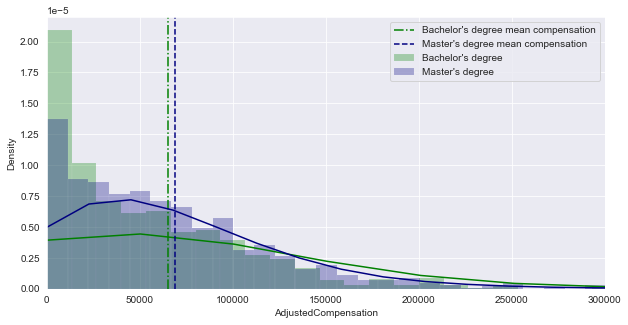

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

# bachelor's
sns.histplot(data=bachelors, stat='density', kde=True, bins='auto', color="green", alpha=.3, label="Bachelor's degree")
plt.axvline(x=bachelors.mean(), color='green', ls="-.", label="Bachelor's degree mean compensation", lw=1.5)

# master's
sns.histplot(data=masters, stat='density', kde=True, bins='auto', color="navy", alpha=.3, label="Master's degree")
plt.axvline(x=masters.mean(), color='navy', ls="--", label="Master's degree mean compensation", lw=1.5)

ax.set_xlim(0, 300000)
plt.legend()
plt.show();

In [9]:
# compare the two groups: mean, median, sd

print("Adjusted Compensation")
print("Bachelor's Degree vs. Master's Degree")
print("mean:")
print(f"    ${int(bachelors.mean())} : ${int(masters.mean())}")
print(f"    difference: ${(int(masters.mean()))-(int(bachelors.mean()))}")
print("median:")
print(f"    ${int(bachelors.median())} : ${int(masters.median())}")
print(f"    difference: ${(int(masters.median()))-(int(bachelors.median()))}")
print("standard deviation:")
print(f"    {int(bachelors.std())} : {int(masters.std())}")
print("sample size:")
print(f"    {len(bachelors)} : {len(masters)}")



Adjusted Compensation
Bachelor's Degree vs. Master's Degree
mean:
    $64887 : $69139
    difference: $4252
median:
    $38399 : $53812
    difference: $15413
standard deviation:
    306935 : 135527
sample size:
    1107 : 1990


In [10]:
# find the p-value
t_stat, p_value = stats.ttest_ind(bachelors, masters, equal_var=False, nan_policy='omit') # equal_var=False: Welch's T-test
oneside_pval = p_value/2
oneside_pval

0.33077639451272445

In [11]:
# conclusions
"""
The p-value of .33 is not less than the alpha threshold of .05, 
therefore, I have failed to reject the null hypothesis. 
There is no significant relationship between a budding data 
scientist's formal education of a Bachelor's vs a Master's degree 
and their adjusted compensation.
"""
oneside_pval < alpha

False

In [12]:
# copy paste functions from past labs, visualization aids
def get_sample(data, n):
    sample = []
    while len(sample) < n:
        sample.append(np.random.choice(data))
    return sample


def create_sample_distribution(data, dist_size, n):
    sample_dist = []
    while len(sample_dist) < dist_size:
        sample = get_sample(data, n)
        sample_mean = np.mean(sample)
        sample_dist.append(round(sample_mean, 3))
    return sample_dist


In [13]:
########################

# CLAUDE, CHECK BELOW.

# I took 2000 samples (sample size 30) of data and visually 
# (ie somewhat arbitrarily) decided a threshold for
# "you obviously don't belong" data. Then, (it gets worse)
# I made a second cut to grab the 99% of my visual edit, ie
# "ok, sure, you look like you belong but I only want 
# the inner bits of you" data and used that for new 
# p value (outliers removed)... it doesn't feel 'right' but 
# not sure how else to do it.
# There has to be a numeric way to do this properly.

########################

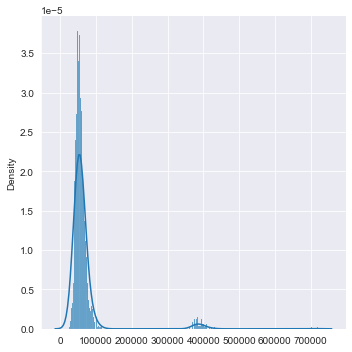

In [14]:
# bachelor's 
dist_size = 2000
n = 30
b_data_1k = create_sample_distribution(bachelors, dist_size, n)

sns.displot(data=b_data_1k, x=b_data_1k, kind="kde")
sns.histplot(data=b_data_1k, stat='density', bins='auto')
#sns.histplot(data=data_1k, kde=True, stat='density', bins='auto')
plt.show();


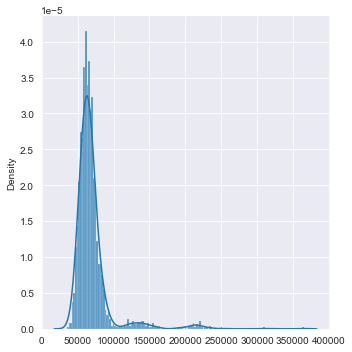

In [15]:
# master's 
dist_size = 2000
n = 30
m_data_1k = create_sample_distribution(masters, dist_size, n)

sns.displot(data=m_data_1k, x=m_data_1k, kind="kde")
sns.histplot(data=m_data_1k, stat='density', bins='auto')

plt.show();

In [16]:
# remove outliers 
no_out_b = [salery for salery in b_data_1k if salery < 150000]
no_out_m = [salery for salery in m_data_1k if salery < 175000]

# calculate means
b_x_bar = np.mean(no_out_b)
m_x_bar = np.mean(no_out_m)

# calculate standard deviations
b_s = np.std(no_out_b)
m_s = np.std(no_out_m)

In [17]:
# compare the two groups: mean, median, sd

print("Adjusted Compensation")
print("Bachelor's Degree vs. Master's Degree")
print("mean:")
print(f"    ${int(b_x_bar)} : ${int(m_x_bar)}")
print(f"    difference: ${(int(m_x_bar))-(int(b_x_bar))}")
print("median:")
print(f"    ${int(np.median(no_out_b))} : ${int(np.median(no_out_m))}")
print(f"    difference: ${(int(np.median(no_out_m)))-(int(np.median(no_out_b)))}")
print("standard deviation:")
print(f"    {int(b_s)} : {int(m_s)}")
print("sample size:")
print(f"    {len(no_out_b)} : {len(no_out_m)}")



Adjusted Compensation
Bachelor's Degree vs. Master's Degree
mean:
    $55234 : $66903
    difference: $11669
median:
    $53535 : $64094
    difference: $10559
standard deviation:
    12643 : 16752
sample size:
    1941 : 1964


In [18]:
# calculate 99% ranges, 3 sd's from mean
b_right_99 = round(b_x_bar+(3*b_s), 2)
m_right_99 = round(m_x_bar+(3*m_s), 2)

In [19]:
b_sans_out = [salery for salery in bachelors if salery < b_right_99]
m_sans_out = [salery for salery in bachelors if salery < m_right_99] 

In [20]:
# find the p-value with outliers removed
t_stat, p_value = stats.ttest_ind(b_sans_out, m_sans_out, equal_var=False, nan_policy='omit') # equal_var=False: Welch's T-test
oneside_pval = p_value/2
oneside_pval

3.580242889475543e-07

In [21]:
# conclusions with outliers removed
# p-value changes every time it runs so I intentionally did not write it out
"""
The p-value is less than the alpha threshold of .05, 
therefore, I have rejected the null hypothesis. 
There is a relationship between a budding data 
scientist's formal education of a Bachelor's vs a Master's degree 
and their adjusted compensation.
"""
oneside_pval < alpha

True

In [22]:
# find effect size?

In [23]:
########################

# CLAUDE, end here that method, tried something diff below
########################

In [24]:
#Your code here

## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

In [25]:
#Your code here

In [26]:
# sample 1 = bachelors
bachelors = ed_sal[ed_sal['FormalEducation'] == "Bachelor's degree"]["AdjustedCompensation"]

# sample 2 = doctoral
doctoral = ed_sal[ed_sal['FormalEducation'] == "Doctoral degree"]["AdjustedCompensation"]

In [27]:
# compare the two groups: mean, median, sd

print("Adjusted Compensation")
print("Bachelor's Degree vs. Doctoral Degree")
print("mean:")
print(f"    ${int(bachelors.mean())} : ${int(doctoral.mean())}")
print(f"    difference: ${(int(doctoral.mean()))-(int(bachelors.mean()))}")
print("median:")
print(f"    ${int(bachelors.median())} : ${int(doctoral.median())}")
print(f"    difference: ${(int(doctoral.median()))-(int(bachelors.median()))}")
print("standard deviation:")
print(f"    {int(bachelors.std())} : {int(doctoral.std())}")
print("sample size:")
print(f"    {len(bachelors)} : {len(doctoral)}")


Adjusted Compensation
Bachelor's Degree vs. Doctoral Degree
mean:
    $64887 : $29566175
    difference: $29501288
median:
    $38399 : $74131
    difference: $35732
standard deviation:
    306935 : 909998082
sample size:
    1107 : 967


In [28]:
# find the p-value
t_stat, p_value = stats.ttest_ind(bachelors, doctoral, equal_var=False, nan_policy='omit') # equal_var=False: Welch's T-test
oneside_pval = p_value/2
oneside_pval

0.15682381994720257

In [29]:
# conclusions
"""
The p-value of .16 is not less than the alpha threshold of .05, 
therefore, I have failed to reject the null hypothesis. 
There is no significant relationship between a budding data 
scientist's formal education of a Bachelor's vs a Doctoral degree 
and their adjusted compensation.
"""
oneside_pval < alpha

False

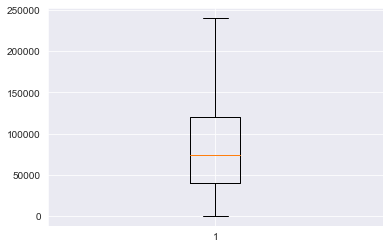

In [30]:
# trying something else to remove outliers
# visualize doctoral first

# unhash to visualize outliers
#plt.boxplot(doctoral, showfliers=True)

plt.boxplot(doctoral, showfliers=False)
plt.show();

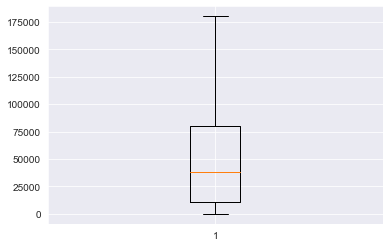

In [31]:
# visualize bachelor's next

# unhash to visualize outliers
#plt.boxplot(bachelors, showfliers=True)

plt.boxplot(bachelors, showfliers=False)
plt.show();

In [32]:
# remove outliers with quantiles

# set values
d_q1 = np.quantile(doctoral, .25)
d_q3 = np.quantile(doctoral, .75)
d_iqr = stats.iqr(doctoral)

# remove outliers 
d = []
for ad_comp in doctoral:
    if ad_comp >= d_q1-(1.5*d_iqr) and ad_comp <= d_q3+(1.5*d_iqr):
        d.append(ad_comp)

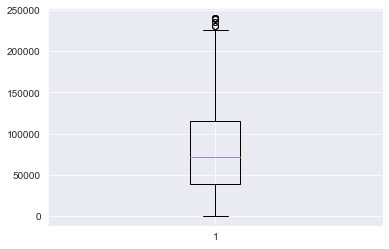

In [33]:
# visually compare to above
plt.boxplot(d, showfliers=True)
plt.show();

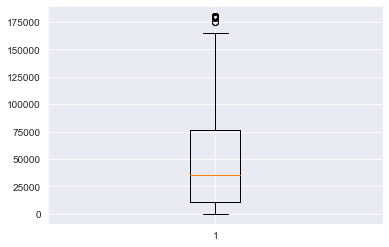

In [34]:
# repeat for bachelor's
# set values
b_q1 = np.quantile(bachelors, .25)
b_q3 = np.quantile(bachelors, .75)
b_iqr = stats.iqr(bachelors)

# remove outliers 
b = []
for ad_comp in bachelors:
    if ad_comp >= b_q1-(1.5*b_iqr) and ad_comp <= b_q3+(1.5*b_iqr):
        b.append(ad_comp)

# visually compare
plt.boxplot(b, showfliers=True)
plt.show();

In [35]:
# find the p-value with outliers removed
t_stat, p_value = stats.ttest_ind(b, d, equal_var=False, nan_policy='omit') # equal_var=False: Welch's T-test
oneside_pval = p_value/2
oneside_pval

1.1304814995613013e-46

In [36]:
# conclusions with outliers removed
"""
After removing the outliers from both the Bachelor's and 
Doctoral degrees, the p-value dropped to well below the alpha
threshold of .05, therefore, I have rejected the null 
hypothesis and concluded that there is a relationship between 
adjusted compensation and level of formal education.
"""
oneside_pval < alpha

True

## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [37]:
#Your code here

####### CLAUDE #######

# Where do I go from here to compare with outliers removed, 
# I have two list (b, d, not df's), I'd have to make list for 
# Master's with outliers removed using quartiles
# pd.DataFrame?


In [38]:
ed_sal.tail(2)

,FormalEducation,AdjustedCompensation
26255,Master's degree,89686.95
26378,Master's degree,10000.00


In [39]:
formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, ed_sal).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

# anova same as two sided t test? so divide value by 2?
# what am I looking at here?

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.540294e+17     6.0  0.590714  0.738044
Residual            7.999414e+20  4335.0       NaN       NaN


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!